In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
print(os.getcwd())

/kaggle/working


In [3]:
os.chdir("../input/predict-volcanic-eruptions-ingv-oe")
print(os.getcwd())

/kaggle/input/predict-volcanic-eruptions-ingv-oe


****データをざっくり確認****

In [4]:
train=pd.read_csv('train.csv')
train.head()

,segment_id,time_to_eruption
0,1136037770,12262005
1,1969647810,32739612
2,1895879680,14965999
3,2068207140,26469720
4,192955606,31072429


In [5]:
sample_submission=pd.read_csv('sample_submission.csv')#index_col=0にはしない
sample_submission.head()

,segment_id,time_to_eruption
0,1000213997,0
1,100023368,0
2,1000488999,0
3,1001028887,0
4,1001857862,0


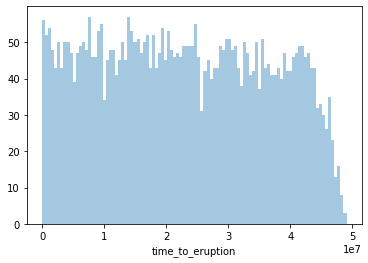

In [6]:
sns.distplot(train["time_to_eruption"],bins=100,kde=False)

In [7]:
train['time_to_eruption'].describe()

count    4.431000e+03
mean     2.284891e+07
std      1.348439e+07
min      6.250000e+03
25%      1.127016e+07
50%      2.246559e+07
75%      3.434356e+07
max      4.904609e+07
Name: time_to_eruption, dtype: float64

In [8]:
import glob
train_files=glob.glob("train/*")
print(len(train_files))

#len([idx for idx in train.index])#indexが数字なのでidxも数字

4431


In [9]:
test_files=glob.glob("test/*")
print(len(test_files))

4520


In [10]:
check=pd.read_csv(train_files[0])
check.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
0,-560.0,-508.0,NaN,-261.0,-348.0,1681.0,-764.0,-1193.0,NaN,-516.0
1,-508.0,-460.0,NaN,-276.0,-252.0,1934.0,-774.0,-1276.0,NaN,-537.0
2,-630.0,-260.0,NaN,-310.0,-174.0,2229.0,-785.0,-1298.0,NaN,-535.0
3,-587.0,1.0,NaN,-352.0,-69.0,2069.0,-788.0,-1249.0,NaN,-507.0
4,-778.0,240.0,NaN,-390.0,71.0,1850.0,-825.0,-1402.0,NaN,-437.0


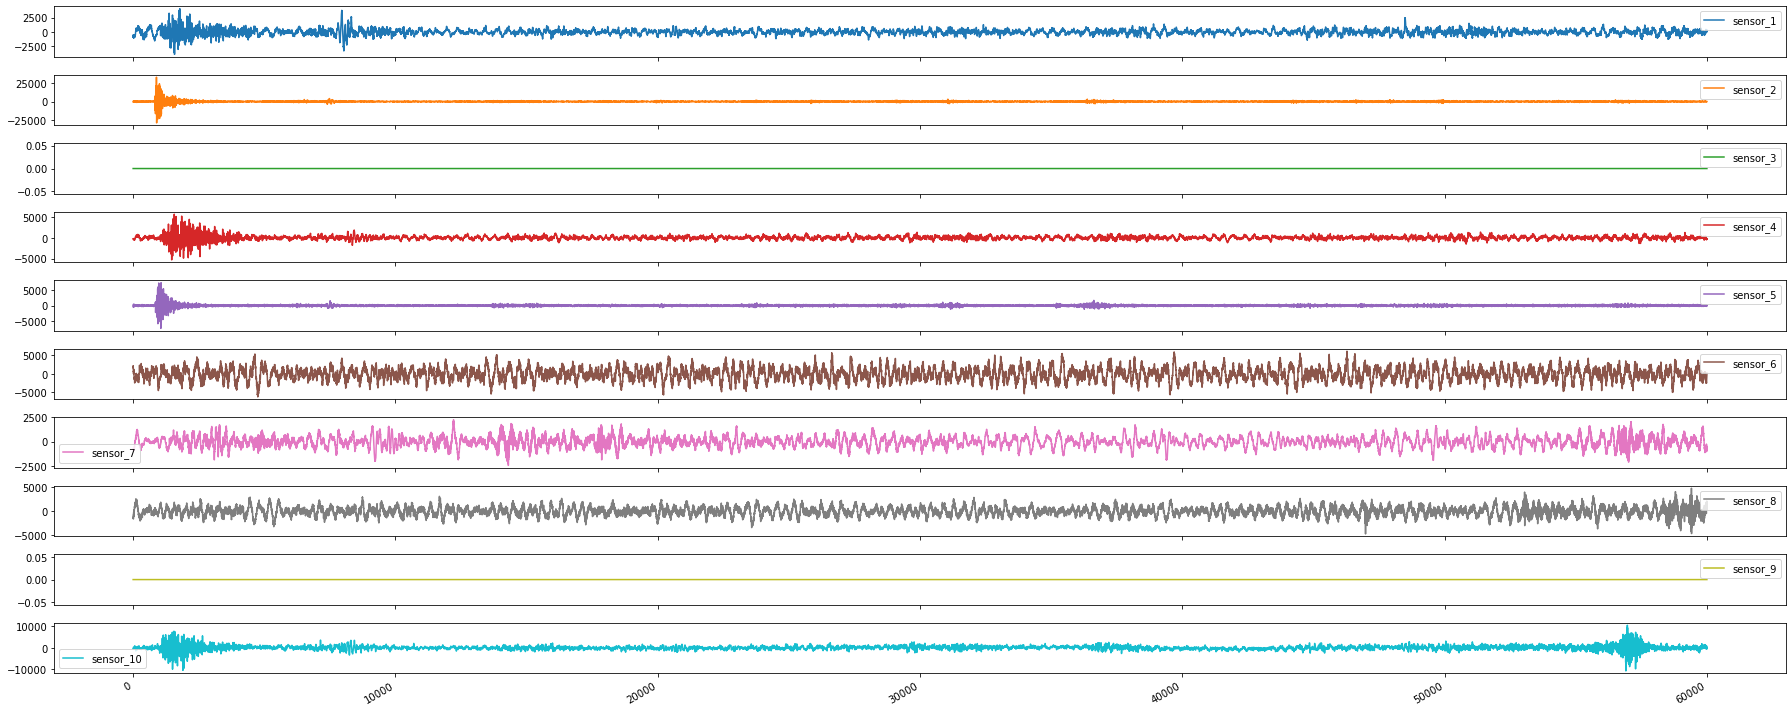

In [11]:
check.fillna(0).plot(subplots=True, figsize=(25,10))
plt.tight_layout()

統計データの確認とか

In [12]:
def agg_stats(df,idx):
    df=df.agg(['sum','min','mean','std','median',"skew","kurtosis"])
    df_flat=df.stack()
    df_flat.index=df_flat.index.map('{0[1]}_{0[0]}'.format) #https://stackoverflow.com/questions/48385525/what-does-df-columns-df-columns-map0001-format-mean-exactly
    df_out=df_flat.to_frame().T#横一列のdataframe
    df_out["segment_id"]=int(idx)
    return df_out

In [13]:
from tqdm import tqdm

summary_stats=pd.DataFrame()
for csv in tqdm(train_files):
    df=pd.read_csv(csv)
    summary_stats=summary_stats.append(agg_stats(df, csv.split("/")[1].split(".")[0]))#appendじゃなくてconcatでもいいはず
    #https://teratail.com/questions/121789

100%|██████████| 4431/4431 [11:10<00:00,  6.61it/s]


In [14]:
features=list(summary_stats.drop(["segment_id"], axis=1).columns)
target_names=["time_to_eruption"]
summary_stats=summary_stats.merge(train,on="segment_id")
summary_stats.head()

,sensor_1_sum,sensor_2_sum,sensor_3_sum,sensor_4_sum,sensor_5_sum,sensor_6_sum,sensor_7_sum,sensor_8_sum,sensor_9_sum,sensor_10_sum,...,sensor_9_mean,sensor_3_std,sensor_9_std,sensor_3_median,sensor_9_median,sensor_3_skew,sensor_9_skew,sensor_3_kurtosis,sensor_9_kurtosis,time_to_eruption
0,246860.0,190832.0,0.0,222795.0,-23542.0,-1633857.0,-378117.0,-250538.0,0.0,539840.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16818516
1,-8760.0,-110423.0,-158561.0,-45063.0,-72167.0,-49231.0,-184887.0,148202.0,205683.0,4258.0,...,3.427993,583.100251,680.014886,0.0,0.0,-0.018962,0.002706,0.173209,0.200506,10340827
2,49504.0,0.0,166995.0,70822.0,43758.0,-130730.0,-67101.0,0.0,154.0,-207969.0,...,0.002567,247.931506,289.998896,0.0,0.0,0.122184,0.012443,1.560024,1.297561,40087733
3,-89445.0,68666.0,-322248.0,116084.0,-31568.0,1507883.0,1447249.0,-366456.0,452929.0,936166.0,...,7.548691,526.238300,541.287068,0.0,0.0,-0.044987,0.059949,-0.006577,0.252821,31317486
4,-44225.0,405037.0,234170.0,171577.0,6933.0,-208817.0,86905.0,70251.0,94008.0,298896.0,...,1.566774,331.748050,343.404396,0.0,0.0,-0.052081,-0.002466,3.931743,2.108477,5801334


In [15]:
summary_stats.describe()

,sensor_1_sum,sensor_2_sum,sensor_3_sum,sensor_4_sum,sensor_5_sum,sensor_6_sum,sensor_7_sum,sensor_8_sum,sensor_9_sum,sensor_10_sum,...,sensor_9_mean,sensor_3_std,sensor_9_std,sensor_3_median,sensor_9_median,sensor_3_skew,sensor_9_skew,sensor_3_kurtosis,sensor_9_kurtosis,time_to_eruption
count,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,...,4307.000000,3996.000000,4307.000000,3996.0,4307.0,3996.000000,4307.000000,3996.000000,4307.000000,4.431000e+03
mean,-3.154637e+04,6.642264e+04,-7.115497e+04,-6.911549e+03,1.703888e+05,8.371901e+03,-9.131113e+03,-3.930828e+02,-6.063665e+03,-1.970177e+04,...,-0.088121,658.951399,677.088265,0.0,0.0,-0.000991,-0.003657,1.779537,2.248869,2.284891e+07
std,1.074697e+06,4.234405e+06,1.454592e+06,1.199746e+06,4.345850e+06,1.432993e+06,1.206980e+06,1.390008e+06,1.227877e+06,2.005872e+06,...,20.776701,1533.866852,1626.207259,0.0,0.0,0.114722,0.093619,10.429411,7.854015,1.348439e+07
min,-3.572893e+07,-1.471348e+07,-3.467549e+07,-2.729633e+07,-6.630852e+06,-4.027425e+07,-4.723766e+07,-5.815644e+07,-2.519325e+07,-6.419481e+07,...,-419.880502,83.034849,102.552075,0.0,0.0,-1.165676,-2.739765,-1.163593,-0.876845,6.250000e+03
25%,-1.072995e+05,-8.585300e+04,-1.087195e+05,-9.845400e+04,-2.699850e+04,-1.762360e+05,-1.396805e+05,-1.101665e+05,-8.263250e+04,-1.987590e+05,...,-1.455901,242.923509,284.182257,0.0,0.0,-0.037239,-0.029876,0.174041,0.256607,1.127016e+07
50%,1.062000e+03,0.000000e+00,0.000000e+00,-1.022000e+03,0.000000e+00,1.836000e+03,7.731000e+03,0.000000e+00,0.000000e+00,5.861000e+03,...,0.040475,321.968464,346.935743,0.0,0.0,-0.001881,-0.001719,0.426267,0.669426,2.246559e+07
75%,1.095300e+05,8.361850e+04,8.270450e+04,9.850450e+04,2.645550e+04,1.744185e+05,1.313650e+05,1.173110e+05,8.784450e+04,2.270125e+05,...,1.526947,534.883686,514.422366,0.0,0.0,0.033900,0.024996,1.183498,1.803676,3.434356e+07
max,2.047363e+07,2.687404e+08,3.331265e+07,3.894129e+07,1.799850e+08,5.094290e+07,2.035339e+07,4.406151e+07,4.512942e+07,6.134024e+07,...,752.144481,19900.334691,18925.747540,0.0,0.0,2.085865,0.886424,448.313264,264.051749,4.904609e+07


In [16]:
import lightgbm as lgm
from sklearn.model_selection import train_test_split,KFold

In [17]:
#初心者でよくわからんので、とりあえず、全部突っ込む！
train=summary_stats.drop(["segment_id","time_to_eruption"],axis=1)
y=summary_stats['time_to_eruption']

In [18]:
train,val,y,y_val=train_test_split(train,y,random_state=42, test_size=0.2, shuffle=True)

In [19]:
import optuna
from optuna.samplers import TPESampler
import math
from sklearn.metrics import mean_squared_error


sampler=TPESampler(seed=42)

def create_model(trial):
    num_leaves=trial.suggest_int("num_leaves",2,31)
    n_estimators=trial.suggest_int("n_estimators",50,300)
    max_depth=trial.suggest_int("max_depth",3,8)
    min_child_samples=trial.suggest_int("min_child_samples",100,1200)
    learning_rate=trial.suggest_uniform("learning_rate",0.0001,0.99)
    min_data_in_leaf=trial.suggest_int('min_data_in_leaf',5,90)
    feature_fraction=trial.suggest_uniform('feature_fraction',0.0001,1.0)
    
    model=lgm.LGBMRegressor(
    num_leaves=num_leaves,
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_child_samples=min_child_samples,
    min_data_in_leaf=min_data_in_leaf,
    learning_rate=learning_rate,
    feature_fraction=feature_fraction,
    random_state=666)
    
    return model

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true,y_pred))

#目的関数
def objective(trial):
    model=create_model(trial)
    model.fit(train,y)
    preds=model.predict(val)
    score=rmse(y_val,preds)
    return score

In [20]:
study=optuna.create_study(direction="minimize", sampler=sampler)
#ログを表示したくない時
#optuna.logging.disable_default_handler()
study.optimize(objective, n_trials=100)

[I 2020-12-30 00:38:56,280] A new study created in memory with name: no-name-f11800f3-6534-4172-8e38-568cfaf6d946
[I 2020-12-30 00:38:56,503] Trial 0 finished with value: 8411934.46688005 and parameters: {'num_leaves': 8, 'n_estimators': 229, 'max_depth': 7, 'min_child_samples': 1195, 'learning_rate': 0.5927120335066465, 'min_data_in_leaf': 87, 'feature_fraction': 0.10006491832642109}. Best is trial 0 with value: 8411934.46688005.
[I 2020-12-30 00:38:56,644] Trial 1 finished with value: 9878128.974595934 and parameters: {'num_leaves': 12, 'n_estimators': 137, 'max_depth': 7, 'min_child_samples': 971, 'learning_rate': 0.7010210447603055, 'min_data_in_leaf': 26, 'feature_fraction': 0.056505937869197546}. Best is trial 0 with value: 8411934.46688005.
[I 2020-12-30 00:38:57,448] Trial 2 finished with value: 12536474.366884932 and parameters: {'num_leaves': 25, 'n_estimators': 285, 'max_depth': 8, 'min_child_samples': 905, 'learning_rate': 0.0008709003060200837, 'min_data_in_leaf': 64, 'fea

[I 2020-12-30 00:39:20,839] Trial 24 finished with value: 7215218.695521078 and parameters: {'num_leaves': 29, 'n_estimators': 240, 'max_depth': 4, 'min_child_samples': 616, 'learning_rate': 0.3299167426097419, 'min_data_in_leaf': 45, 'feature_fraction': 0.8499985928828755}. Best is trial 13 with value: 6835219.289726515.
[I 2020-12-30 00:39:21,615] Trial 25 finished with value: 7092325.647729149 and parameters: {'num_leaves': 22, 'n_estimators': 298, 'max_depth': 5, 'min_child_samples': 728, 'learning_rate': 0.2225775530782665, 'min_data_in_leaf': 58, 'feature_fraction': 0.34843110473670447}. Best is trial 13 with value: 6835219.289726515.
[I 2020-12-30 00:39:22,574] Trial 26 finished with value: 6956550.186756975 and parameters: {'num_leaves': 27, 'n_estimators': 225, 'max_depth': 5, 'min_child_samples': 415, 'learning_rate': 0.08017562294869623, 'min_data_in_leaf': 46, 'feature_fraction': 0.5884090405856333}. Best is trial 13 with value: 6835219.289726515.
[I 2020-12-30 00:39:23,614

[I 2020-12-30 00:40:29,355] Trial 49 finished with value: 7498363.034096179 and parameters: {'num_leaves': 22, 'n_estimators': 219, 'max_depth': 8, 'min_child_samples': 308, 'learning_rate': 0.406359312513907, 'min_data_in_leaf': 31, 'feature_fraction': 0.7843453494241033}. Best is trial 34 with value: 6416810.466113352.
[I 2020-12-30 00:40:31,645] Trial 50 finished with value: 9916469.805516722 and parameters: {'num_leaves': 13, 'n_estimators': 287, 'max_depth': 8, 'min_child_samples': 460, 'learning_rate': 0.9663453004483548, 'min_data_in_leaf': 16, 'feature_fraction': 0.9549982300157869}. Best is trial 34 with value: 6416810.466113352.
[I 2020-12-30 00:40:34,333] Trial 51 finished with value: 6710503.074883091 and parameters: {'num_leaves': 21, 'n_estimators': 156, 'max_depth': 7, 'min_child_samples': 384, 'learning_rate': 0.16423321694943055, 'min_data_in_leaf': 23, 'feature_fraction': 0.86533558033028}. Best is trial 34 with value: 6416810.466113352.
[I 2020-12-30 00:40:35,822] Tr

[I 2020-12-30 00:41:48,381] Trial 74 finished with value: 6463368.909141495 and parameters: {'num_leaves': 29, 'n_estimators': 291, 'max_depth': 6, 'min_child_samples': 629, 'learning_rate': 0.07732106956658641, 'min_data_in_leaf': 10, 'feature_fraction': 0.9417009062925822}. Best is trial 34 with value: 6416810.466113352.
[I 2020-12-30 00:41:53,394] Trial 75 finished with value: 6698517.236133706 and parameters: {'num_leaves': 29, 'n_estimators': 291, 'max_depth': 6, 'min_child_samples': 638, 'learning_rate': 0.035072401445776585, 'min_data_in_leaf': 7, 'feature_fraction': 0.96107506989967}. Best is trial 34 with value: 6416810.466113352.
[I 2020-12-30 00:41:57,399] Trial 76 finished with value: 6519863.182508517 and parameters: {'num_leaves': 28, 'n_estimators': 299, 'max_depth': 6, 'min_child_samples': 752, 'learning_rate': 0.07320279179134917, 'min_data_in_leaf': 10, 'feature_fraction': 0.8174569334759825}. Best is trial 34 with value: 6416810.466113352.
[I 2020-12-30 00:42:01,803]

[I 2020-12-30 00:43:18,852] Trial 99 finished with value: 6425171.6400222145 and parameters: {'num_leaves': 31, 'n_estimators': 261, 'max_depth': 6, 'min_child_samples': 518, 'learning_rate': 0.16119091329073099, 'min_data_in_leaf': 13, 'feature_fraction': 0.9097494356347839}. Best is trial 34 with value: 6416810.466113352.


In [21]:
#最適解
print(study.best_params)
print(study.best_value)
print(study.best_trial)

{'num_leaves': 21, 'n_estimators': 298, 'max_depth': 8, 'min_child_samples': 430, 'learning_rate': 0.10036048373064771, 'min_data_in_leaf': 16, 'feature_fraction': 0.9468197686025577}
6416810.466113352
FrozenTrial(number=34, value=6416810.466113352, datetime_start=datetime.datetime(2020, 12, 30, 0, 39, 38, 836531), datetime_complete=datetime.datetime(2020, 12, 30, 0, 39, 42, 310402), params={'num_leaves': 21, 'n_estimators': 298, 'max_depth': 8, 'min_child_samples': 430, 'learning_rate': 0.10036048373064771, 'min_data_in_leaf': 16, 'feature_fraction': 0.9468197686025577}, distributions={'num_leaves': IntUniformDistribution(high=31, low=2, step=1), 'n_estimators': IntUniformDistribution(high=300, low=50, step=1), 'max_depth': IntUniformDistribution(high=8, low=3, step=1), 'min_child_samples': IntUniformDistribution(high=1200, low=100, step=1), 'learning_rate': UniformDistribution(high=0.99, low=0.0001), 'min_data_in_leaf': IntUniformDistribution(high=90, low=5, step=1), 'feature_fractio

In [22]:
params=study.best_params
params["random_state"]=42

In [23]:
lgb = lgm.LGBMRegressor(**params)
lgb.fit(train, y)
preds=lgb.predict(val)
print('Optimized LGB model rmse: ', rmse(y_val, preds))

Optimized LGB model rmse:  6513505.068725593


このパラメータを使って提出してみようか...

In [24]:
sample_submission

,segment_id,time_to_eruption
0,1000213997,0
1,100023368,0
2,1000488999,0
3,1001028887,0
4,1001857862,0
...,...,...
4515,996704281,0
4516,997630809,0
4517,998072137,0
4518,998136924,0


テストデータについても、同じ作業をする

In [26]:
from tqdm import tqdm

summary_stats_test=pd.DataFrame()
for csv in tqdm(test_files):
    df=pd.read_csv(csv)
    summary_stats_test=summary_stats_test.append(agg_stats(df, csv.split("/")[1].split(".")[0]),ignore_index=True)#appendじゃなくてconcatでもいいはず
    #https://teratail.com/questions/121789

100%|██████████| 4520/4520 [11:05<00:00,  6.79it/s]


In [27]:
summary_stats_test.head()

,sensor_1_sum,sensor_2_sum,sensor_3_sum,sensor_4_sum,sensor_5_sum,sensor_6_sum,sensor_7_sum,sensor_8_sum,sensor_9_sum,sensor_10_sum,...,sensor_8_kurtosis,sensor_9_kurtosis,sensor_10_kurtosis,segment_id,sensor_2_min,sensor_2_mean,sensor_2_std,sensor_2_median,sensor_2_skew,sensor_2_kurtosis
0,176053.0,0.0,256674.0,-332689.0,-132049.0,513231.0,-144172.0,91820.0,-57767.0,-182668.0,...,0.047616,0.599324,0.311241,473253715,NaN,NaN,NaN,NaN,NaN,NaN
1,-163264.0,-163473.0,210484.0,-160025.0,-160063.0,-138917.0,63258.0,-19571.0,-141810.0,314689.0,...,0.674631,1.549404,2.389208,698018079,-32767.0,-2.724505,1742.047382,0.0,-0.333724,31.380589
2,-61271.0,0.0,0.0,-39293.0,-35512.0,13346.0,331228.0,2194.0,38243.0,0.0,...,-0.030561,0.425849,0.000000,1102809614,NaN,NaN,NaN,NaN,NaN,NaN
3,23641.0,8068.0,88471.0,-99968.0,41230.0,72076.0,-27421.0,-95106.0,106812.0,-627041.0,...,1.255523,0.689637,0.168186,1087681649,-2396.0,0.134464,400.391725,0.0,0.013306,0.938544
4,-217318.0,0.0,-204164.0,-31475.0,16878.0,142299.0,84423.0,0.0,3441.0,-145282.0,...,NaN,3.120450,4.527737,1939361933,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
test=summary_stats_test.drop(["segment_id"], axis=1)

In [32]:
pred1=lgb.predict(test)

In [33]:
summary_stats_test['time_to_eruption']=pred1

In [34]:
sample_submission=pd.merge(sample_submission,summary_stats_test[["segment_id","time_to_eruption"]], on="segment_id" )

In [35]:
sample_submission.head()

,segment_id,time_to_eruption_x,time_to_eruption_y
0,1000213997,0,3.039647e+07
1,100023368,0,2.932759e+07
2,1000488999,0,2.080419e+07
3,1001028887,0,2.274480e+07
4,1001857862,0,2.691626e+07


In [36]:
sample_submission=sample_submission.drop(['time_to_eruption_x'],axis=1)
sample_submission.columns=['segment_id',"time_to_eruption"]
sample_submission

,segment_id,time_to_eruption
0,1000213997,3.039647e+07
1,100023368,2.932759e+07
2,1000488999,2.080419e+07
3,1001028887,2.274480e+07
4,1001857862,2.691626e+07
...,...,...
4515,996704281,3.121167e+07
4516,997630809,3.492667e+07
4517,998072137,2.730783e+07
4518,998136924,2.492007e+07


In [40]:
sample_submission.to_csv("/kaggle/working/submission1.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: '../kaggle/working/submission1.csv'